# Using a Gaussian Process to model timeseries count data

Using model from paper by Allanach et al. (2020)
https://www.damtp.cam.ac.uk/user/bca20/ramp.pdf

## Goal
Given a series of counts (admissions, census, etc.) $$y(t) \text{ for } t = 1, ..., T$$ where $t$ is an integer representing a date in time. Assuming $t = T$ is today, want to predict counts $$y(T+1), y(T+2), ..., y(T+7)$$ for the week ahead.

## Model
We will represent data as input/output pairs $(t,s(t))$, where $s(t) = \ln y(t)$. We will suppose that $s(t)$ is a Gaussian Process
$$s \sim N(\mu(t), \sigma(t,t'))$$
with zero mean
$$\mu(t) = 0$$
and squared exponential covariance
$$\sigma(t,t') = a^2 \exp\left(-\frac{(t-t')^2}{2l^2}\right) + v \delta_{tt'}$$

We will sample from the posterior predictive distribution to extrapolate log counts for days $T+1, ..., T+7$.

## Hyperparameters
- $a$ - amplitude
- $l$ - characteristic time-scale
- $v$ - variance of observational noise

In [50]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [51]:
train_df = pd.read_csv("../Middlesex.csv")
y = train_df['cases'].values

T = len(y)
t = np.arange(T)[:,None]
s = np.log(y)

In [52]:
with pm.Model() as model:
    a = pm.HalfNormal('amplitude', sigma=10)
    l = pm.HalfNormal('time-scale', sigma=10)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # Mean function defaults to `Zero`.
    
    v = pm.HalfNormal('noise', sigma=10)
    s_ = gp.marginal_likelihood('s', X=t, y=s, noise=v)

    mp = pm.find_MAP()

logp = -16.062, ||grad|| = 0.37937: 100%|██████████| 17/17 [00:00<00:00, 1017.34it/s] 


In [53]:
for param in ['amplitude', 'time-scale', 'noise']:
    print(param, mp[param])

amplitude 5.780637615667856
time-scale 10.510122837158038
noise 0.1568681471438953


In [54]:
X_new = np.arange(T+7)[:,None]

with model:
    s_pred = gp.conditional('s_pred', X_new, pred_noise=True)
    s_samples = pm.sample_posterior_predictive([mp], vars=[s_pred], samples=2000)

100%|██████████| 2000/2000 [00:05<00:00, 358.50it/s]


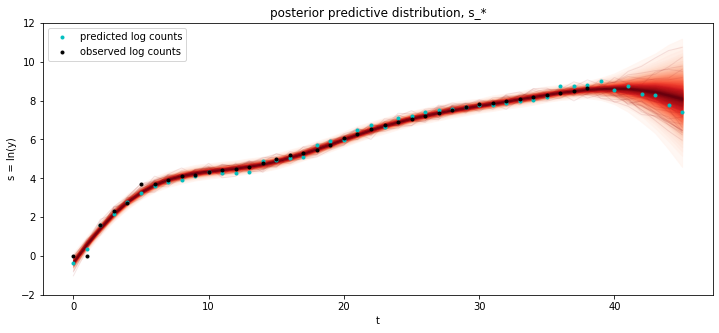

In [55]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, s_samples['s_pred'], X_new, plot_samples=True);

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, s_samples['s_pred'][800, :].T, "co", ms=3, label="predicted log counts");

plt.plot(t, s, 'ok', ms=3, label="observed log counts");

plt.xlabel("t"); plt.ylabel('s = ln(y)'); plt.ylim([-2,12]);
plt.title("posterior predictive distribution, s_*"); plt.legend();

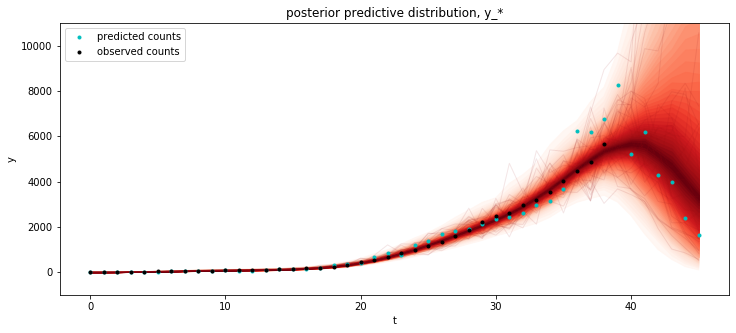

In [56]:
y_samples = np.exp(s_samples['s_pred'])

fig = plt.figure(figsize=(12,5)); ax = fig.gca();
plot_gp_dist(ax, y_samples, X_new);

plt.plot(X_new, y_samples[800, :].T, "co", ms=3, label="predicted counts");
plt.plot(t, y, 'ok', ms=3, label='observed counts');

plt.xlabel('t'); plt.ylabel('y');
plt.ylim([-1000, 11000]);
plt.title('posterior predictive distribution, y_*');

plt.legend();